<a href="https://colab.research.google.com/github/pidoko/CS5330/blob/main/ExplainableAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Image Classifiers with LIME
## CS 5330 - Explainable AI Activity

This notebook will allow you to explore how LIME (Local Interpretable Model-agnostic Explanations) can help us understand why a deep learning model makes specific predictions on images.

# LIME

LIME (Local Interpretable Model-agnostic Explanations) is an explainable AI technique that helps us understand why machine learning models make specific predictions.
In simple terms, LIME works by:
- Taking a prediction made by any "black box" model
- Creating many slightly altered versions of the input data
- Observing how the model's predictions change with these alterations
- Building a simple, interpretable model (like a linear model) that approximates the complex model's behavior around the specific input

For images specifically, LIME typically:
- Divides the image into superpixels (segments of similar pixels)
- Creates variations by hiding different combinations of these segments
- Identifies which segments most positively or negatively impact the prediction

The key advantage of LIME is that it works with any model (model-agnostic) and provides explanations that are understandable to humans. In the computer vision context, it visually highlights which parts of an image are most influential for a particular classification decision.

This Notebook offers a demo of what LIME can do.

In [ ]:
# Installation Guide:
# If you haven't installed these libraries, uncomment and run:
# !pip install lime torch torchvision pillow matplotlib numpy

# Inslat LIME
!pip install lime

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import requests
from io import BytesIO
import os


# PART 1: SETUP

In [ ]:
# Set up the model - we'll use a pre-trained ResNet50
def load_model():
    # Load a pre-trained ResNet model
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.eval()  # Set to evaluation mode
    return model

# Load ImageNet class labels
def get_imagenet_labels():
    labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    response = requests.get(labels_url)
    labels = response.text.strip().split('\n')
    return labels

# Function to preprocess images for the model
def preprocess_image(img):
    # Standard preprocessing for ResNet
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(img).unsqueeze(0)

# Function to make predictions
def predict(model, img_tensor, labels):
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_idx = torch.max(outputs, 1)

        # Get top 5 predictions
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
        top5_probs, top5_indices = torch.topk(probs, 5)

        predictions = []
        for i in range(top5_indices.size(0)):
            idx = top5_indices[i].item()
            predictions.append((labels[idx], top5_probs[i].item()))

    return predictions

# Create a function that LIME can use to get predictions
def batch_predict(images):
    model = load_model()
    batch = torch.stack([preprocess_image(Image.fromarray(img))[0] for img in images])
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1).detach().numpy()
    return probs

# Function to load and display an image
def load_and_display_image(image_path):
    if image_path.startswith('http'):
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")
    plt.show()

    return img

# PART 2: LIME EXPLANATION

In [ ]:
def explain_prediction(img, num_features=5, num_samples=1000):
    """
    Generate and visualize LIME explanations for the image

    Args:
        img: PIL Image to explain
        num_features: Number of features (superpixels) to include in explanation
        num_samples: Number of samples LIME should use
    """
    # Convert PIL Image to numpy array
    img_array = np.array(img)

    # Setup LIME image explainer
    explainer = lime_image.LimeImageExplainer()

    # Define segmentation algorithm for superpixels
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=4,
                                     max_dist=200, ratio=0.2)

    # Get explanation
    print("Generating LIME explanation (this may take a moment)...")
    explanation = explainer.explain_instance(img_array,
                                           batch_predict,
                                           top_labels=5,
                                           hide_color=0,
                                           num_samples=num_samples,
                                           segmentation_fn=segmenter)

    # Get the top predicted label
    model = load_model()
    labels = get_imagenet_labels()
    img_tensor = preprocess_image(img)
    predictions = predict(model, img_tensor, labels)
    top_label = predictions[0]

    print(f"Top prediction: {top_label[0]} (confidence: {top_label[1]:.4f})")

    # Get and display the explanation for the top prediction
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                              positive_only=True,
                                              num_features=num_features,
                                              hide_rest=False)

    # Display the explanation
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis('off')

    # Highlighted important regions
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("Important Regions")
    plt.axis('off')

    # Mask only
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='RdBu')
    plt.title("Importance Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Show how probability changes when each superpixel is removed
    plt.figure(figsize=(10, 6))
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                              positive_only=False,
                                              num_features=10,
                                              hide_rest=False)
    plt.imshow(mask, cmap='RdBu')
    plt.colorbar(label='Contribution to prediction')
    plt.title(f"How different regions affect the prediction of '{top_label[0]}'")
    plt.axis('off')
    plt.show()

    # Show top 5 predictions
    print("\nTop 5 predictions:")
    for label, prob in predictions:
        print(f"  {label}: {prob:.4f}")

    return explanation

# Fix: Import mark_boundaries
from skimage.segmentation import mark_boundaries

# PART 3: RUN THE ACTIVITY

Welcome to the LIME Image Explanation Activity!

You can use one of our sample images or provide your own local image path.

Sample images:
  1. cat_mouse.jpg
  2. 2731674011_9583bc0d6c_z.jpg
  3. image2.jpg

Enter a number to use a sample image, or enter a local file path: 1


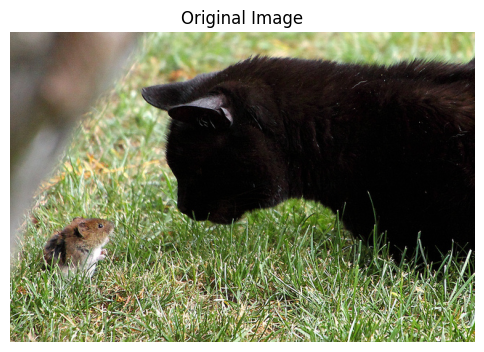

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.0MB/s]



Top 5 predictions:
  Egyptian cat: 0.1440
  tabby: 0.0398
  tiger cat: 0.0277
  American black bear: 0.0164
  schipperke: 0.0164

Do you want to run LIME explanation? (y/n): y
Generating LIME explanation (this may take a moment)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Top prediction: Egyptian cat (confidence: 0.1440)


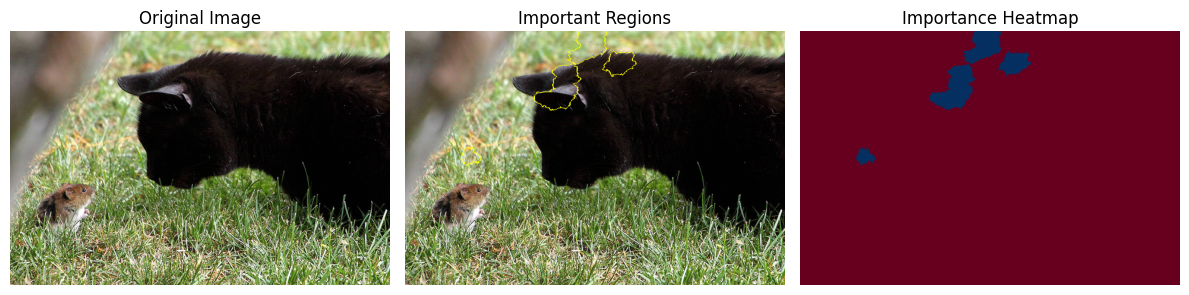

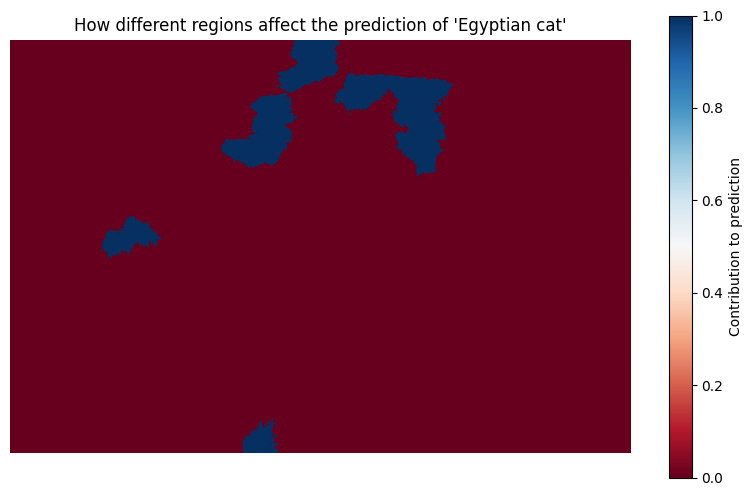


Top 5 predictions:
  Egyptian cat: 0.1440
  tabby: 0.0398
  tiger cat: 0.0277
  American black bear: 0.0164
  schipperke: 0.0164

Do you want to see explanation with different number of superpixels? (y/n): y
Enter number of superpixels to show (1-20): 5
Generating LIME explanation (this may take a moment)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Top prediction: Egyptian cat (confidence: 0.1440)


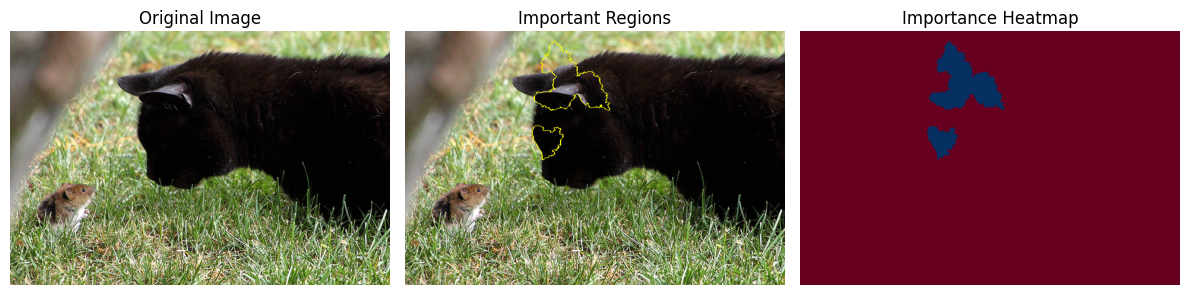

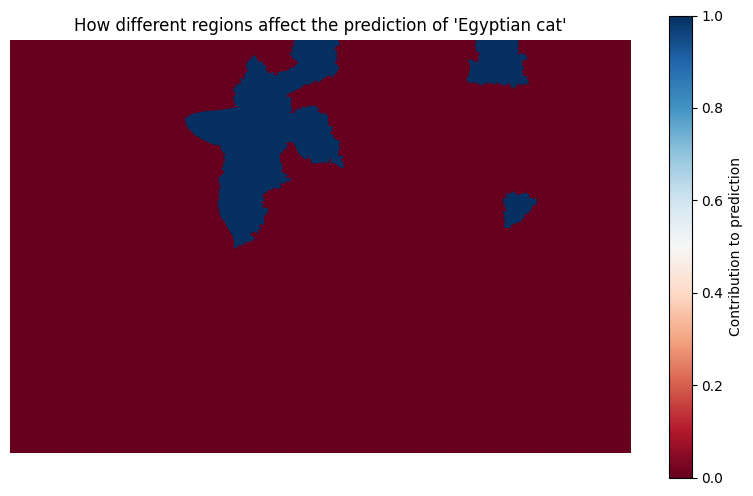


Top 5 predictions:
  Egyptian cat: 0.1440
  tabby: 0.0398
  tiger cat: 0.0277
  American black bear: 0.0164
  schipperke: 0.0164

Reflection Questions:
1. Which parts of the image were most important for the model's prediction?
2. Were these the same parts you would focus on to identify the object?
3. How might you alter the image to change the model's prediction?


In [ ]:
# Example images for students to try
example_images = [
    "https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg",
    "https://farm4.staticflickr.com/3068/2731674011_9583bc0d6c_z.jpg",
    "https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image2.jpg"
]

# Main activity function
def run_lime_activity():
    print("Welcome to the LIME Image Explanation Activity!")
    print("\nYou can use one of our sample images or provide your own local image path.")

    print("\nSample images:")
    for i, img_path in enumerate(example_images):
        print(f"  {i+1}. {img_path.split('/')[-1]}")

    choice = input("\nEnter a number to use a sample image, or enter a local file path: ")

    try:
        if choice.isdigit() and 1 <= int(choice) <= len(example_images):
            image_path = example_images[int(choice)-1]
        else:
            image_path = choice

        img = load_and_display_image(image_path)

        # Get and show model prediction
        model = load_model()
        labels = get_imagenet_labels()
        img_tensor = preprocess_image(img)
        predictions = predict(model, img_tensor, labels)

        print("\nTop 5 predictions:")
        for label, prob in predictions:
            print(f"  {label}: {prob:.4f}")

        # Ask user if they want to run LIME
        run_lime = input("\nDo you want to run LIME explanation? (y/n): ")
        if run_lime.lower() == 'y':
            explanation = explain_prediction(img)

            # Experimental: Try changing num_features
            change_features = input("\nDo you want to see explanation with different number of superpixels? (y/n): ")
            if change_features.lower() == 'y':
                num_features = int(input("Enter number of superpixels to show (1-20): "))
                explanation = explain_prediction(img, num_features=num_features)

            print("\nReflection Questions:")
            print("1. Which parts of the image were most important for the model's prediction?")
            print("2. Were these the same parts you would focus on to identify the object?")
            print("3. How might you alter the image to change the model's prediction?")

    except Exception as e:
        print(f"Error: {e}")
        print("Please try again with a different image.")

# Run the activity
if __name__ == "__main__":
    run_lime_activity()

# PART 4: ADVERSARIAL EXPLORATION
   - Can you identify which pixels to modify to change the prediction?
   - Try creating a minimal change to flip the classification
   - Share your findings
